In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Set the style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Load the dataset
df = pd.read_csv('customer_behavior_analytcis.csv')

# 2. Check for missing values
print("Missing values in the dataset:")
print(df.isnull().sum())

# 3. Handle missing values
# Separate numeric features and customer_id
numeric_features = df.drop('customer_id', axis=1)  # Exclude customer_id
customer_ids = df['customer_id']  # Store customer_id separately

# Impute missing values for numeric features (using mean for numerical columns)
imputer = SimpleImputer(strategy='mean')
numeric_features_imputed = imputer.fit_transform(numeric_features)

# Combine imputed numeric features with customer_id
df_imputed = pd.DataFrame(numeric_features_imputed, columns=numeric_features.columns)
df_imputed['customer_id'] = customer_ids  # Add customer_id back

# Verify no missing values remain
print("\nMissing values after imputation:")
print(df_imputed.isnull().sum())


Missing values in the dataset:
total_purchases     20
avg_cart_value      20
total_time_spent     0
product_click       20
discount_counts      0
customer_id          0
dtype: int64

Missing values after imputation:
total_purchases     0
avg_cart_value      0
total_time_spent    0
product_click       0
discount_counts     0
customer_id         0
dtype: int64


In [2]:
# 4. Data Preprocessing
# Extract features for clustering (exclude customer_id)
features = df_imputed.drop('customer_id', axis=1)
feature_names = features.columns

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=feature_names)

print("\nScaled features (first 5 rows):")
print(scaled_df.head())


Scaled features (first 5 rows):
   total_purchases  avg_cart_value  total_time_spent  product_click  \
0        -0.658436        0.988916          0.086238      -0.634946   
1         1.502265       -0.941123         -1.227549      -0.821002   
2        -1.378670       -0.794296          1.263694       1.349649   
3         1.934405       -0.892119         -1.165497      -0.758984   
4        -0.658436        0.917521         -0.463364       0.109277   

   discount_counts  
0        -0.952061  
1         0.593022  
2        -0.510608  
3         1.255200  
4        -0.289882  


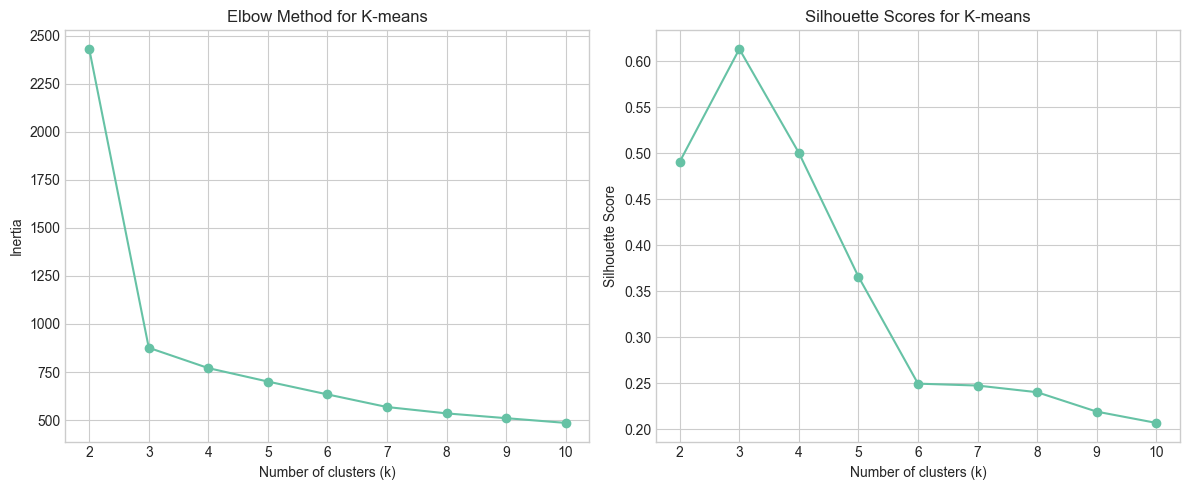

In [3]:
# 5. Model Selection
# Determine optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score for k > 1
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot Elbow Method results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-means')
plt.grid(True)

# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K-means')
plt.grid(True)
plt.tight_layout()
plt.savefig('kmeans_elbow_silhouette.png')
plt.show()


PCA explained variance ratio: [0.63392733 0.26013324]
Total explained variance: 0.8941


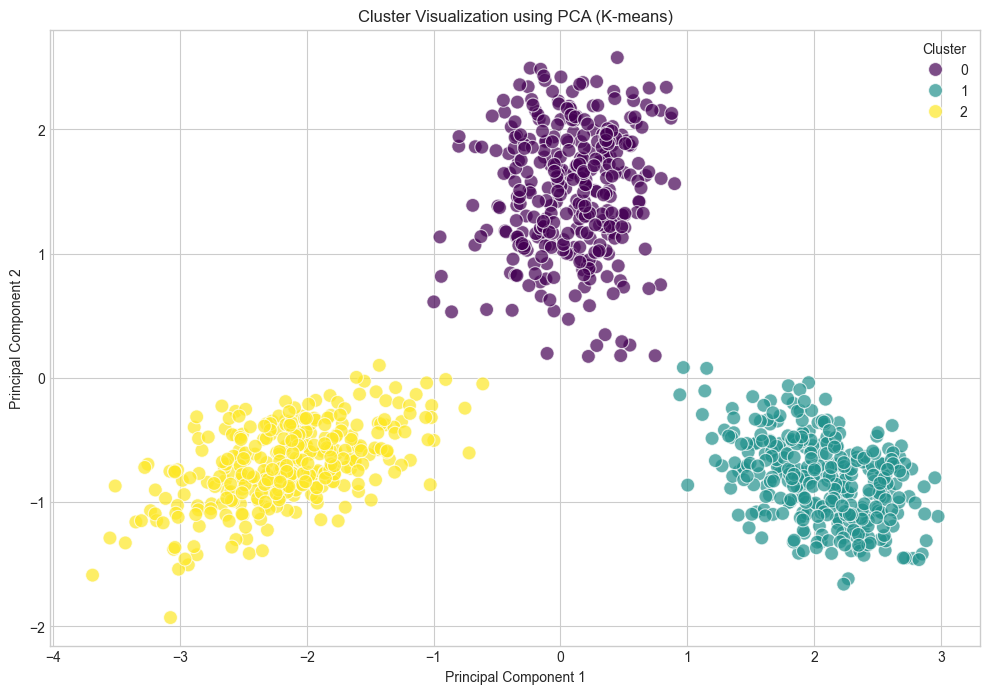

In [4]:
# Based on the problem statement, we know there are 3 clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_features)

# 6. Dimensionality Reduction for Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Explained variance ratio
print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Create a DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

# Visualize clusters in 2D space
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.title('Cluster Visualization using PCA (K-means)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.savefig('cluster_visualization_pca.png')
plt.show()


Cluster Centers (mean values for each feature per cluster):
         total_purchases  avg_cart_value  total_time_spent  product_click  \
Cluster                                                                     
0              10.212991      145.390574         40.472126      20.120186   
1               4.943626       49.348259         90.211837      49.457687   
2              19.540531       31.346684         17.511682      15.224222   

         discount_counts  
Cluster                   
0               1.940120  
1               1.027108  
2               9.969970  


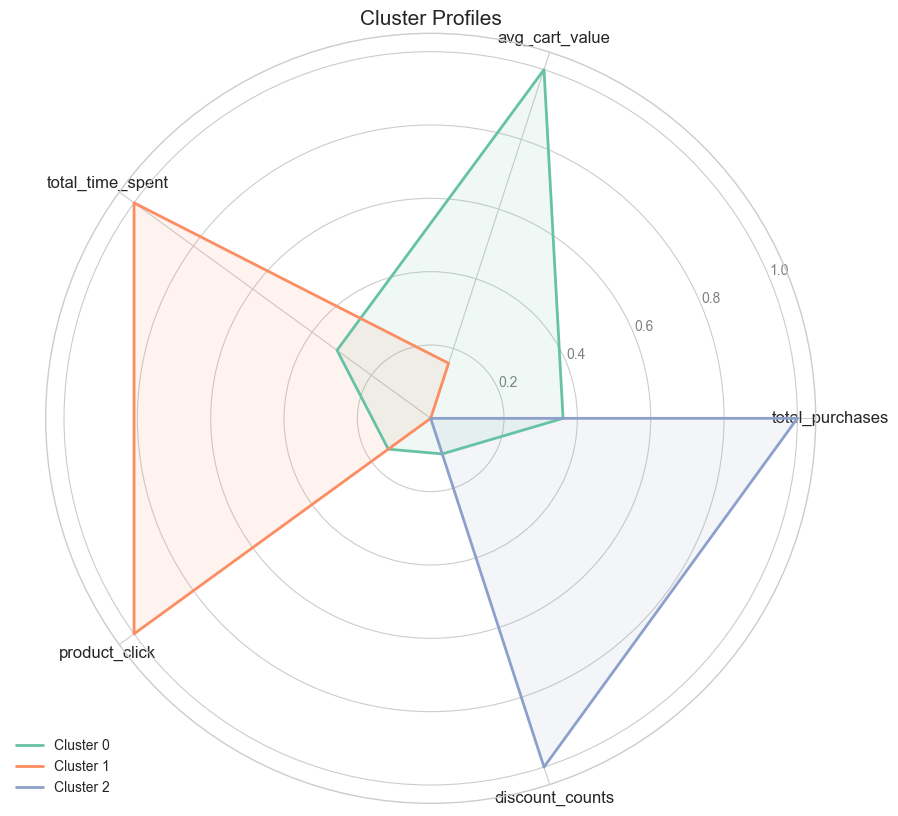

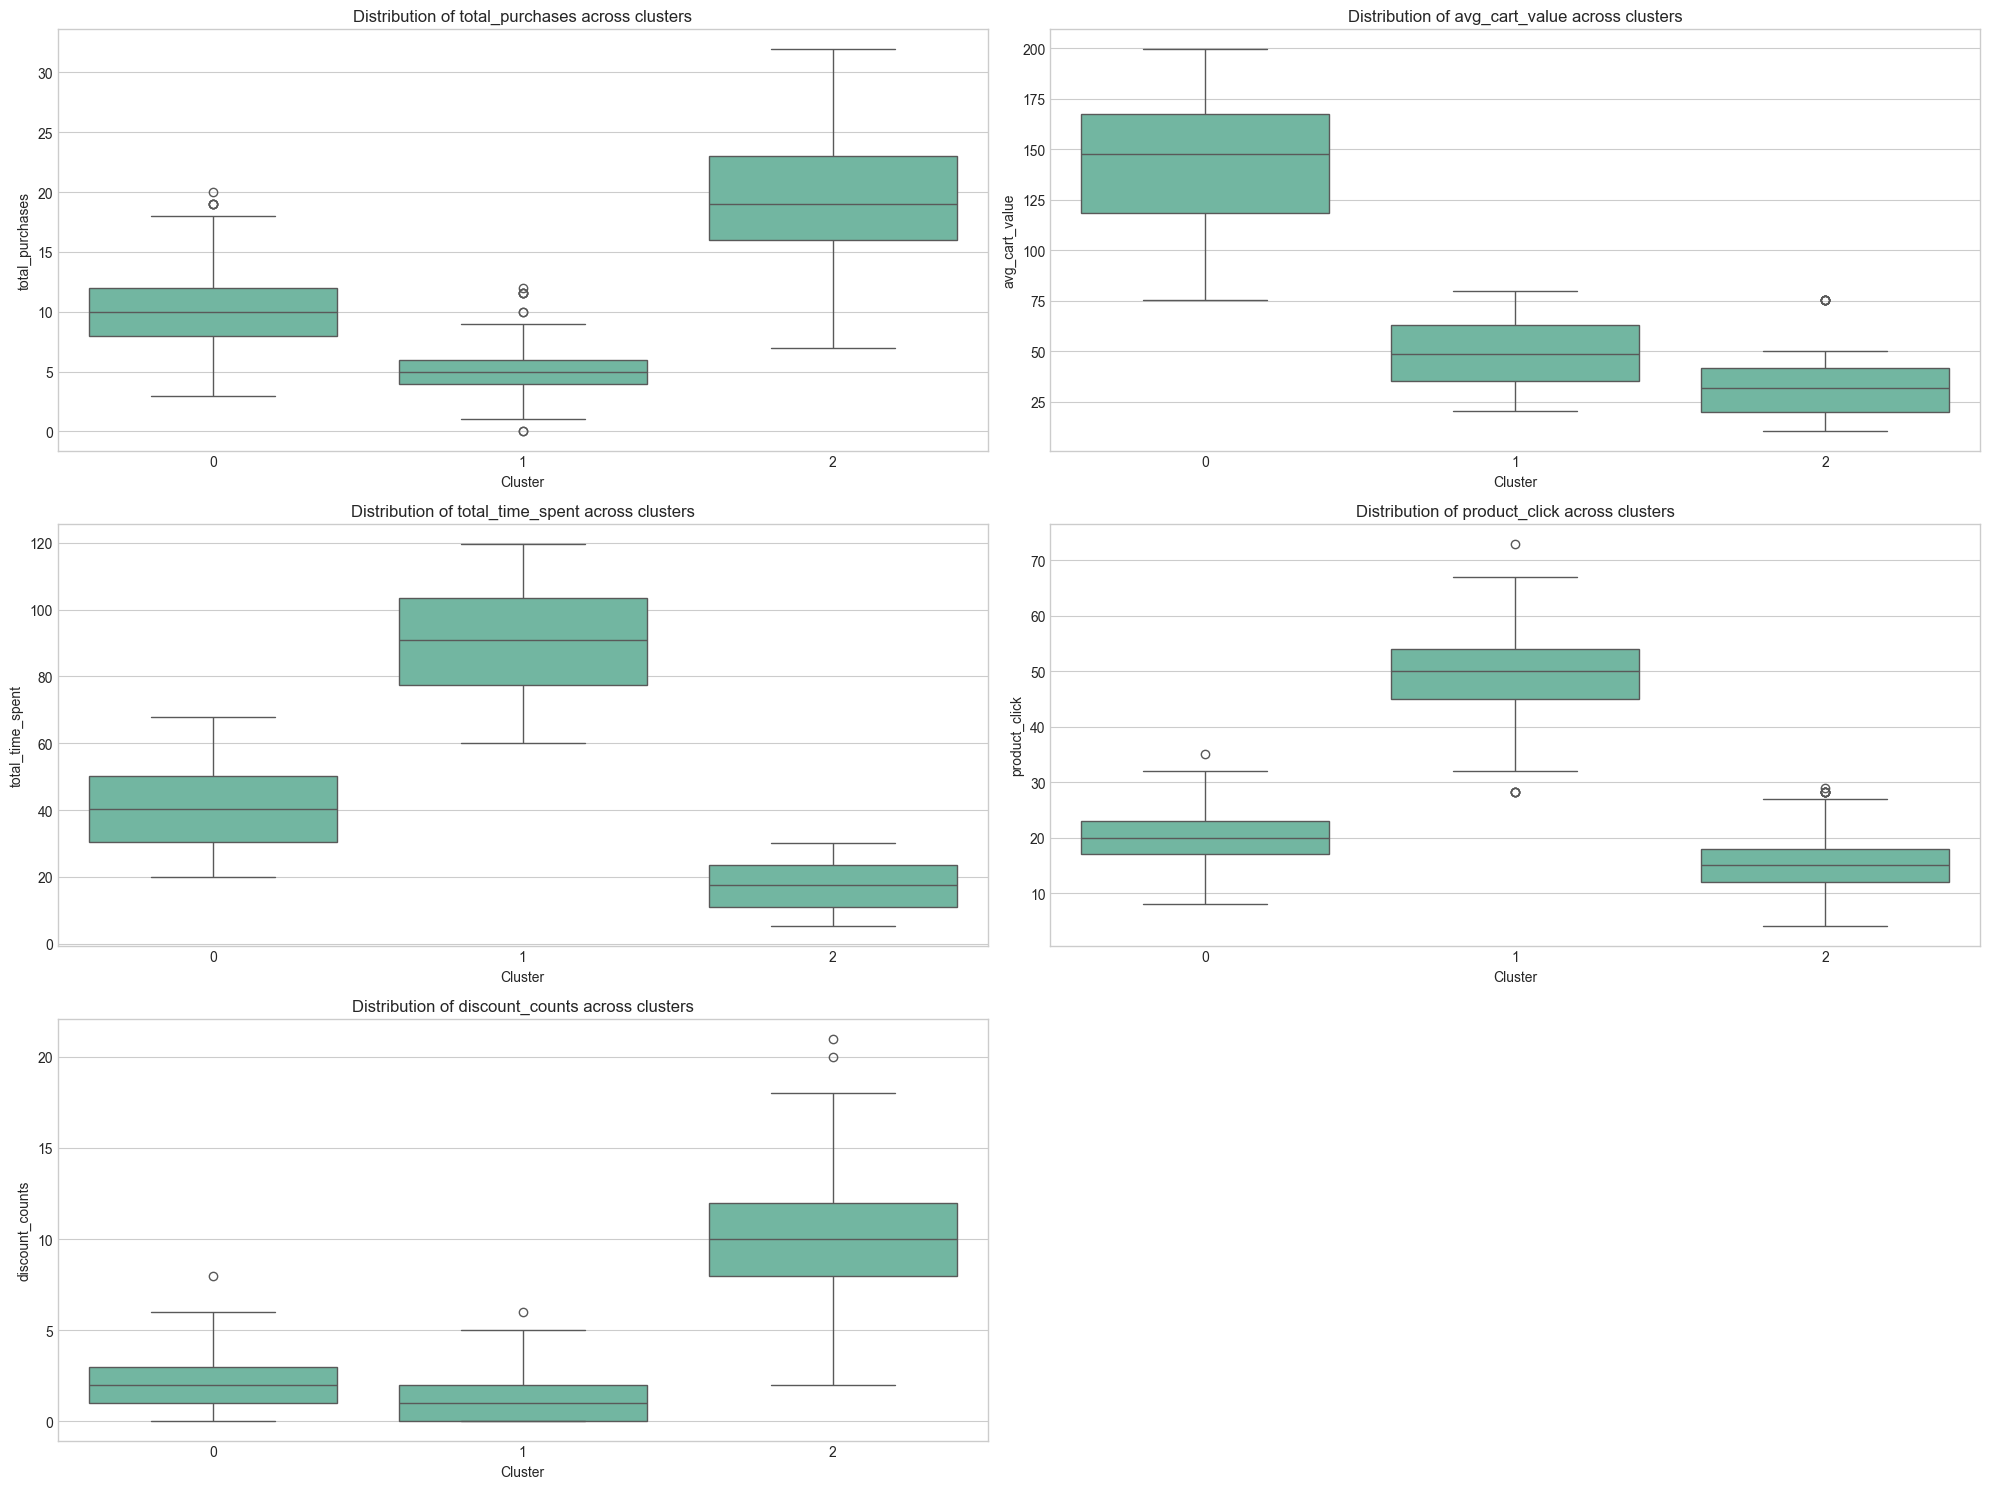

In [5]:
# 7. Cluster Analysis and Interpretation
# Add cluster labels to the original dataframe
df_imputed['Cluster'] = kmeans_labels

# Analyze cluster characteristics (exclude customer_id)
cluster_means = df_imputed.drop('customer_id', axis=1).groupby('Cluster').mean()
print("\nCluster Centers (mean values for each feature per cluster):")
print(cluster_means)

# Radar chart to visualize cluster profiles
def radar_chart(cluster_centers, feature_names):
    n_features = len(feature_names)
    angles = np.linspace(0, 2*np.pi, n_features, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    for i, cluster in enumerate(cluster_centers.index):
        values = cluster_centers.loc[cluster].values.tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.1)
    
    # Set category labels
    plt.xticks(angles[:-1], feature_names, size=12)
    plt.yticks(color="grey", size=10)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Cluster Profiles', size=15)
    plt.savefig('cluster_radar_chart.png')
    plt.show()

# Normalize cluster means for radar chart
cluster_means_normalized = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
radar_chart(cluster_means_normalized, feature_names)

# Boxplots to compare feature distributions across clusters
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Cluster', y=feature, data=df_imputed)
    plt.title(f'Distribution of {feature} across clusters')
plt.tight_layout()
plt.savefig('cluster_feature_boxplots.png')
plt.show()

In [ ]:
# 8. Mapping Clusters to Customer Segments
# Analyze the cluster centers to identify which cluster corresponds to which segment
print("\nMapping clusters to customer segments based on features:")

# Extract the row index of cluster_means with highest discount_count - likely Bargain Hunters
bargain_hunter_idx = cluster_means['discount_counts'].idxmax()
# Extract the row index with highest avg_cart_value - likely High Spenders
high_spender_idx = cluster_means['avg_cart_value'].idxmax()
# The remaining cluster is likely Window Shoppers - should have lowest total_purchases
window_shopper_idx = {0, 1, 2} - {bargain_hunter_idx, high_spender_idx}
window_shopper_idx = list(window_shopper_idx)[0]

print(f"Cluster {bargain_hunter_idx} -> Bargain Hunters")
print(f"Cluster {high_spender_idx} -> High Spenders")
print(f"Cluster {window_shopper_idx} -> Window Shoppers")

# Create a mapping dictionary
segment_mapping = {
    bargain_hunter_idx: 'Bargain Hunters',
    high_spender_idx: 'High Spenders',
    window_shopper_idx: 'Window Shoppers'
}

# Apply the mapping to create a new column with segment names
df_imputed['Segment'] = df_imputed['Cluster'].map(segment_mapping)

# Visualize the final customer segments with the correct labels
pca_df['Segment'] = pca_df['Cluster'].map(segment_mapping)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Segment', data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Customer Segment')
plt.savefig('customer_segments_pca.png')
plt.show()

